In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import pickle
import copy

from sklearn.cluster import KMeans 

### Load the dataset

In [3]:
moves_df = pd.read_csv("../Data/moves_df.csv", dtype={"fen": str})

In [4]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797
...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311


### Calculate the difference between the metric for each move

In [5]:
# same function thatwas used previously, we just check that the dictionary does exist

def dictCorrespondanceIndex_gameIndex(moves_df):
    dict_corres = {}
    index = 0
    for index in tqdm(range(len(moves_df))):
        game_index = moves_df.iloc[index]['game_index']
        if dict_corres.get(game_index) == None:
            dict_corres[game_index] = index
    return dict_corres

# we first check whether the dictionary has already been calculated
try:
    with open('../Data/Metric_creation/dict_correspondance.pkl', 'rb') as f:
        dict_corres = pickle.load(f)
except:
    dict_corres = dictCorrespondanceIndex_gameIndex(moves_df)

In [5]:
#for each game, this functions returns a list containing the differences between the metric of following moves
#the idea is to determine whether a move is good or not, thus we consider how the game evolves after the move is played

def difference_game(game_index):
    i = dict_corres[game_index]
    diff = [moves_df.iloc[i].evaluation]
    i += 1
    while i < len(moves_df) and moves_df.iloc[i].game_index == game_index:
        eval_i = moves_df.iloc[i].evaluation
        eval_prev = moves_df.iloc[i-1].evaluation
        diff.append(eval_i - eval_prev)
        i += 1
    return diff

In [6]:
#we calculate the differences for each game

differences = []
total_games = moves_df.iloc[-1].game_index
game_index = 0
for game_index in tqdm(range(total_games+1)):
    differences += difference_game(game_index)

# Elbow method for K-Means

We want to train a model to recognize good moves from bad moves, so as to be able to play a game of chess on its own. To do that, we must first create the classes of moves, that our model will then predict. To really distinguish between the moves, we use K-Means to differentiate the moves and place them in the same cluster when they are similar. This will be our classes, that we will try tro predict using supervised learning later on. 

### Elbow method for K-Means

The elbow method is a way to determine how many clusters to use with our K-Means. </br> We calculate the inertia of the K-Means for different number of clusters, plot the evolution of the inertia and determine (visually) where the "elbow" is. </br>
The inertia is also known as the "winthing-cluter sum-o-squares criterion", as is calculated vit the formula:

$$
\text{Inertia = } \sum_{k=1}^n \sum_{x_i \in A_k} ||x - c_k||^2
$$
$\newline \text{where n represents the number of clusters, } A_k \text{ are the clusters, and the } c_k \text{ are their centers.}$

In [10]:
X = np.array(differences).reshape(-1, 1)

In [26]:
inertia=[]

for n_clusters in tqdm(range(2, 26)):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X)
    
    inertia.append(kmeans.inertia_)

100%|██████████| 24/24 [35:18<00:00, 88.28s/it] 


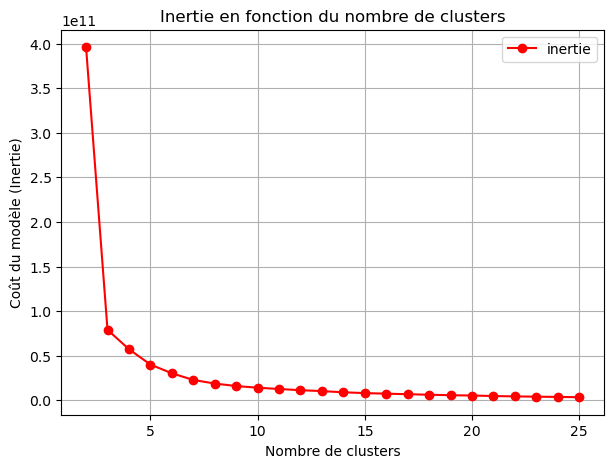

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(2, len(inertia)+2), inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()

According to the elbow method, 5 clusters seems to be the optimal number to select.

### K-Means with 5 clusters

In [11]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
y = kmeans.predict(X)

[ 583929    4727    3977  691822 7739068]


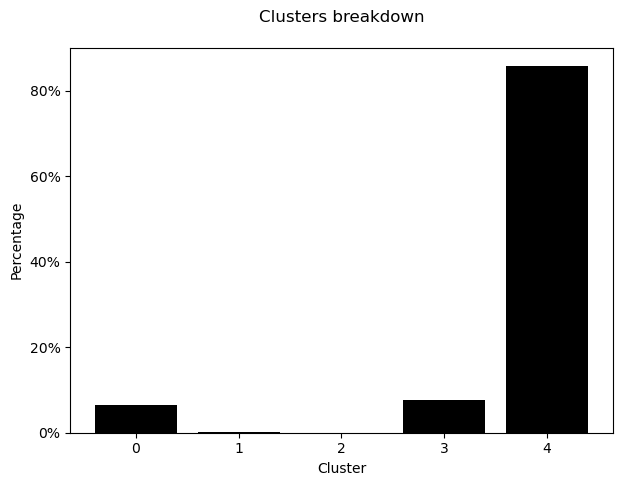

In [12]:
plt.figure(figsize=(7,5))
labels, counts = np.unique(y, return_counts=True)
counts_pct = counts / len(y)
print(counts)
plt.bar(labels, counts_pct, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Clusters breakdown\n')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.show()

##### Calculate the mean difference by cluster

We calculate the mean value of each cluster, to understand better what the clusters represent. 

In [13]:
metric_mean_by_cluster = [0]*len(labels)
for i in tqdm(range(len(y))):
    cluster = y[i]
    metric_mean_by_cluster[cluster] += moves_df.iloc[i].evaluation

100%|██████████| 9023523/9023523 [14:43<00:00, 10210.87it/s]


In [14]:
for i in range(len(metric_mean_by_cluster)):
    metric_mean_by_cluster[i] /= counts[i]

In [15]:
print(metric_mean_by_cluster)

[252.9706933548428, 7643.363444044849, -5971.394015589641, -89.73411947003709, 43.327128537958316]


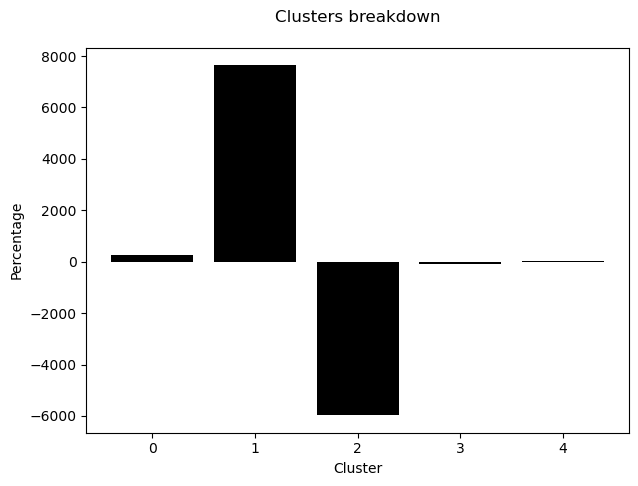

In [16]:
plt.figure(figsize=(7,5))
plt.bar(labels, metric_mean_by_cluster, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.title('Clusters breakdown\n')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.show()

It is intersting to see how our K-Means has divided the moves. Basically, and without to much surprise, we can the creation of 5 classes: </br> • class 0: represents the moves that give the white player an advantage
</br> • class 1: represents the moves that give the white player a huge advantage, making this player very likely to win the game
</br> • class 2: same as class 1, but giving the huge advantage to the black player
</br> • class 3: same as class 0, but giving the advantage to the black player
</br> • class 4: giving neither player any real advantage

In [17]:
ordered_means = copy.deepcopy(metric_mean_by_cluster)
ordered_means.sort()

def get_order_of_cluster(i):
    cluster = y[i]
    cluster_mean = metric_mean_by_cluster[cluster]
    for j in range(len(ordered_means)):
        if cluster_mean == ordered_means[j]:
            return j

In [18]:
# we sort the clusters by ascending mean to make it easier for us to understand and distinguish the classes
# going towards index 0 favors the black player, while going towards the last index favors the white player

clusters_sorted = []
for i in tqdm(range(len(y))):
    cluster_when_sorted = get_order_of_cluster(i)
    clusters_sorted.append(cluster_when_sorted)

100%|██████████| 9023523/9023523 [00:09<00:00, 964492.63it/s] 


### Save the results in the dataset

In [19]:
moves_df['differences'] = differences
moves_df['class'] = clusters_sorted

In [20]:
moves_df.to_csv("../Data/full_moves_df.csv", index=False)

In [21]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key,differences,class
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550,35,2
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928,13,2
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293,63,2
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878,-64,2
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797,5,2
...,...,...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493,-6,2
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573,4,2
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641,14,2
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311,13,2
